# Chapter 3: Truss Optimization

Introduction to quantum annealing using D-Wave systems and QUBO formulations.

---

**Prerequisites:**
- Python 3.8+
- Qiskit 2.1.2
- See `Chapter02_Software.ipynb` for installation instructions


In [1]:
# Setup and imports for D-Wave
import numpy as np
import matplotlib.pyplot as plt

from Chapter03_TrussOptimization_functions import (
    TrussFEM, search_design_space, simulated_annealing)

print('Setup complete!')

Setup complete!


## 3 x 3 truss example

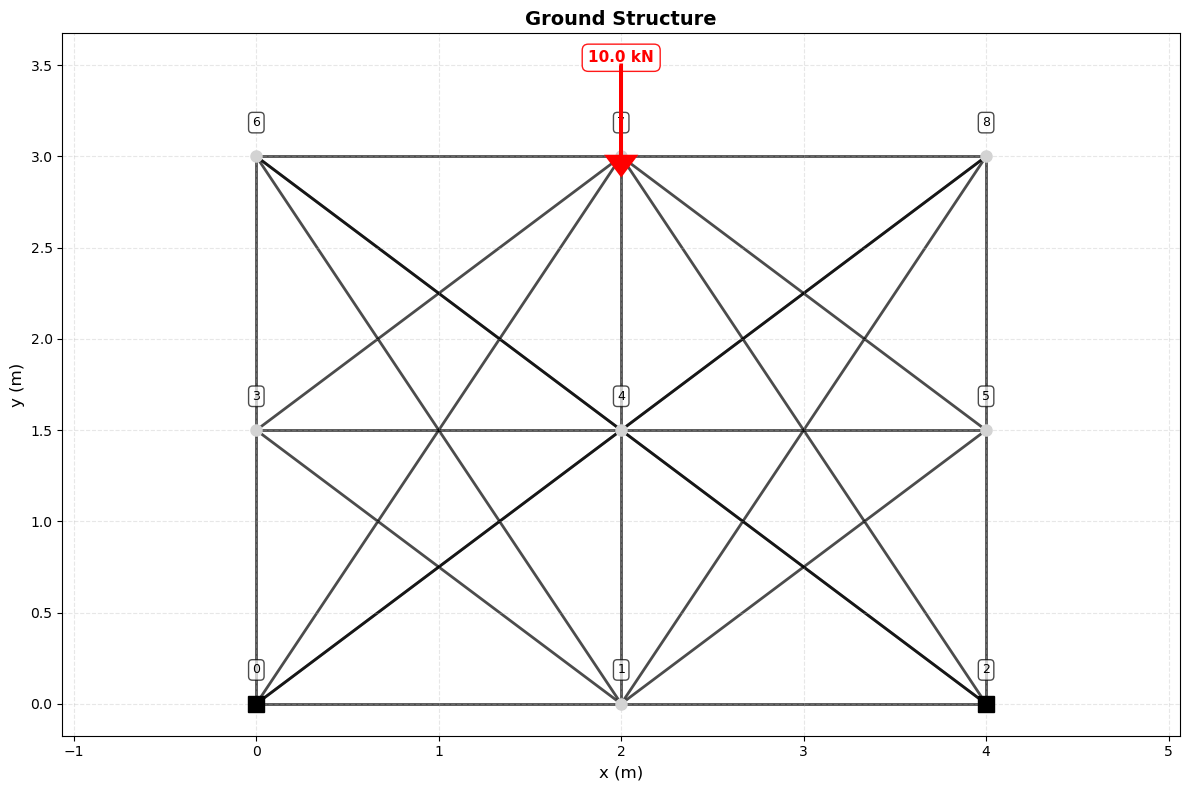

In [2]:
# Example usage with the 3x3 truss
nodes = np.array([
    [0.0, 0.0],   # Node 0 (bottom left) - FIXED
    [2.0, 0.0],   # Node 1 (bottom center)
    [4.0, 0.0],   # Node 2 (bottom right) - FIXED
    [0.0, 1.5],   # Node 3 (middle left)
    [2.0, 1.5],   # Node 4 (middle center)
    [4.0, 1.5],   # Node 5 (middle right)
    [0.0, 3.0],   # Node 6 (top left)
    [2.0, 3.0],   # Node 7 (top center) - LOADED
    [4.0, 3.0]    # Node 8 (top right)
])

elements = [
    (0, 1), (1, 2), (3, 4), (4, 5), (6, 7), (7, 8),  # Horizontal
    (0, 3), (3, 6), (1, 4), (4, 7), (2, 5), (5, 8),  # Vertical
    (0, 4), (1, 3), (1, 5), (2, 4), (3, 7), (4, 6), (4, 8), (5, 7),  # Diagonals
    (0, 8), (2, 6), (0, 7), (1, 6), (1, 8), (2, 7)   # Long diagonals
]

# Create FEM model
fem_model = TrussFEM(nodes, elements, E=200e9, A=0.001, rho=7850)

# Define problem
fixed_dofs = [0, 1, 4, 5]  # Nodes 0 and 2 fixed
loads = np.zeros(2 * len(nodes))
loads[2*7 + 1] = -10000  # 10 kN downward at node 7

# Test with a sample design (all members active)
design_full = np.ones(len(elements), dtype=int)

fem_model.plot_truss(loads=loads, fixed_dofs=fixed_dofs, 
                    show_labels=True,
                    title="Ground Structure")





## Solving and plotting deformed truss

Design valid? True
Max displacement: 0.000057 m


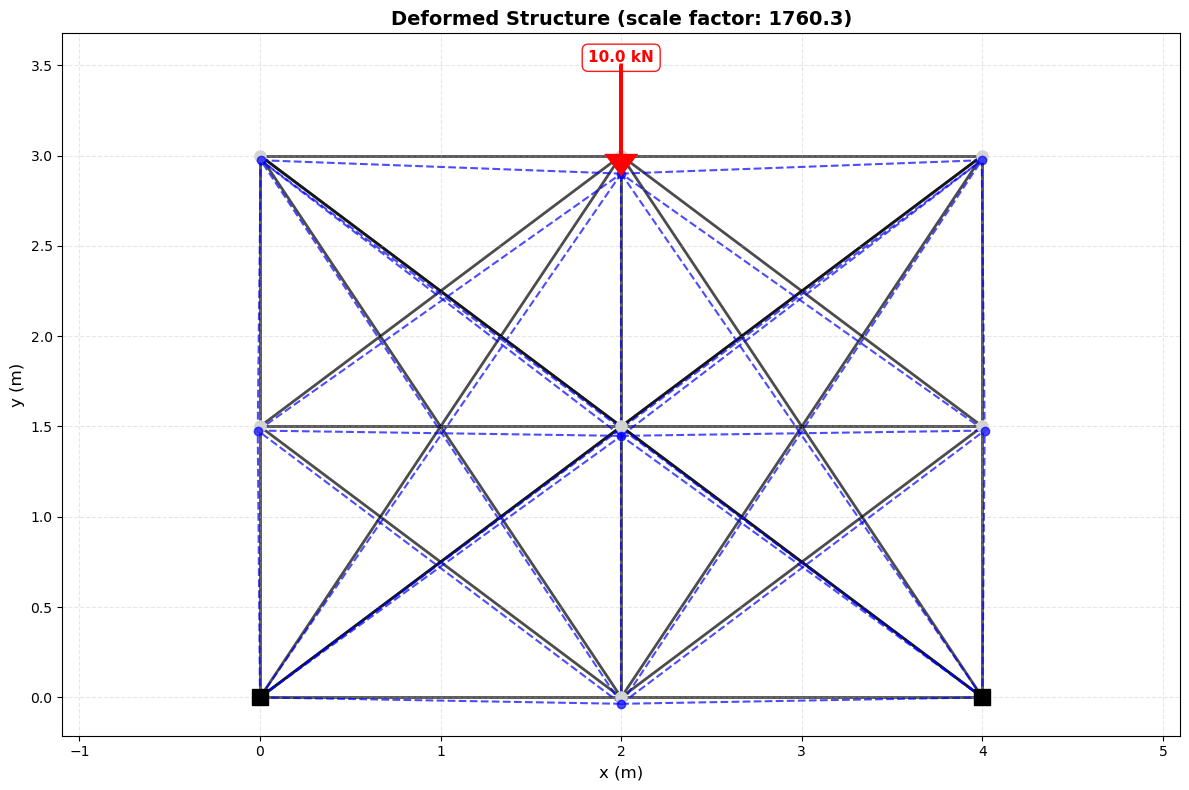

In [3]:
# Solve FEM for full design
u, valid = fem_model.solve(design_full, loads, fixed_dofs)

print(f"Design valid? {valid}")
print(f"Max displacement: {abs(u).max():.6f} m")
# Compute a scaling to visualize deformation
scale_factor = 0.1/abs(u).max()

# plot deformed truss
fem_model.plot_truss(design=design_full, loads=loads, fixed_dofs=fixed_dofs,
                    displacements=u, scale_factor=scale_factor,
                    title=f"Deformed Structure (scale factor: {scale_factor:.1f})")



## Evaluating the metrics

In [4]:
# Design constraints
u_hat = 0.01      # Maximum displacement: 0.01 m = 10 mm
sigma_hat = 250e6 # Yield stress: 250 MPa

metrics = fem_model.evaluate_design(design_full, loads, fixed_dofs, 
                                    u_hat=u_hat, sigma_hat=sigma_hat)


fem_model.print_metrics(metrics)

  Weight: 513.56 kg
  Max displacement: 0.0568 mm
  Max stress: 3.64 MPa
  Compliance: 0.57 J
  Feasible: True


In [5]:

# Example 2: Plot with a specific design

optimal_design = np.array([
    # Horizontal members (indices 0-5)
    1, 1,  # Bottom row: (0,1), (1,2) - CRITICAL for node 1 stability
    1, 1,  # Middle row: (3,4), (4,5) - lateral bracing
    0, 0,  # Top row: not needed (nodes 6,8 hanging)
    
    # Vertical members (indices 6-11)
    1, 0,  # Left column: (0,3) active
    1, 1,  # Center column: (1,4), (4,7) - load path
    1, 0,  # Right column: (2,5) active
    
    # In-square diagonals (indices 12-19)
    1, 0,  # (0,4) diagonal bracing
    0, 1,  # (2,4) diagonal bracing
    1, 0,  # (3,7) diagonal bracing
    0, 1,  # (5,7) diagonal bracing
    
    # Long diagonals (indices 20-25)
    0, 0, 0, 0, 0, 0
], dtype=int)

u_opt, valid_opt = fem_model.solve(optimal_design, loads, fixed_dofs)
print(f"Number of active members: {np.sum(optimal_design)}")  # 10 members

metrics = fem_model.evaluate_design(optimal_design, loads, fixed_dofs, 
                                    u_hat=u_hat, sigma_hat=sigma_hat)


fem_model.print_metrics(metrics)



Number of active members: 12
  Weight: 188.40 kg
  Max displacement: 0.1359 mm
  Max stress: 5.47 MPa
  Compliance: 1.36 J
  Feasible: True


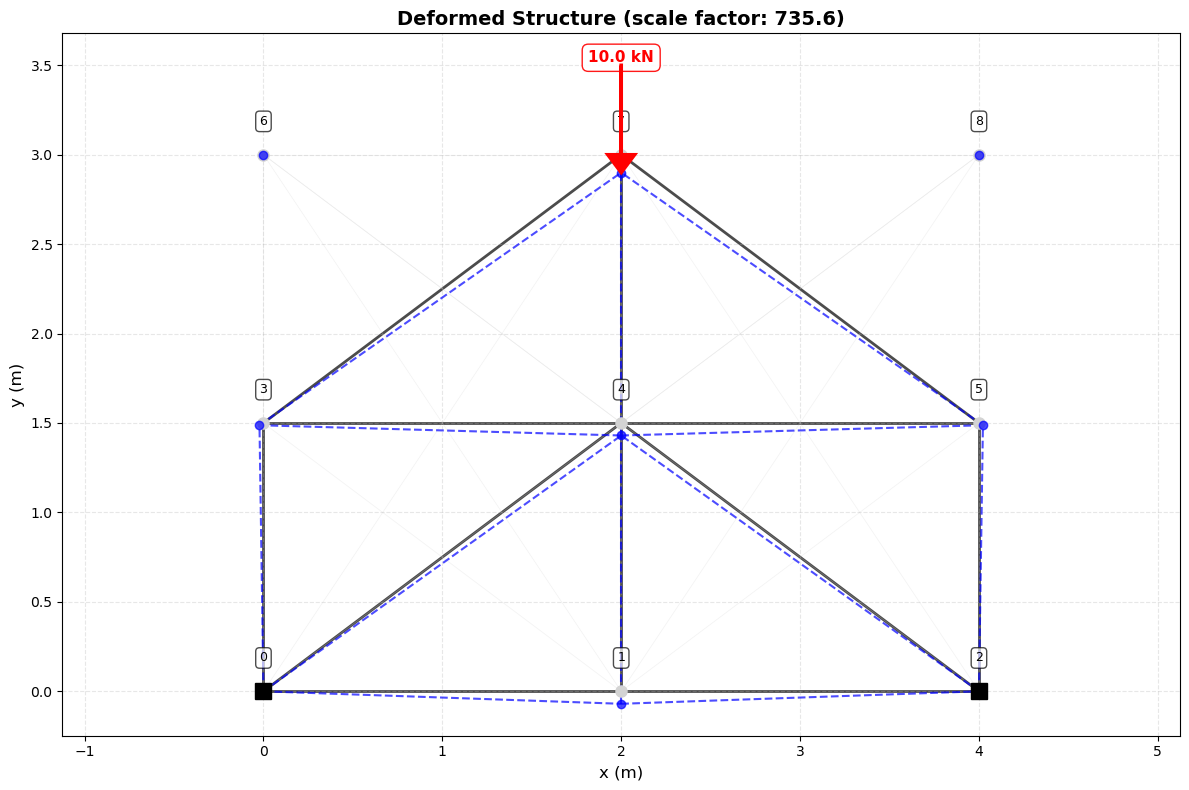

In [6]:
scale_factor =0.1/abs(u_opt).max()
fem_model.plot_truss(design=optimal_design, loads=loads, fixed_dofs=fixed_dofs,
                    displacements=u_opt, scale_factor=scale_factor,
                    show_labels=True,
                    title=f"Deformed Structure (scale factor: {scale_factor:.1f})")


## Random search

In [7]:
N = len(elements) # all elements
M = 100000  # number of random samples
random_search_design = search_design_space(fem_model, loads, fixed_dofs, N, M)



Sampling 100,000 random designs from 2^26 = 67,108,864 possible designs
Sampling rate: 0.1490%

Progress:  10.0% (10,000/100,000) | Elapsed: 1.1s | Remaining: ~10.0s | Feasible: 24
Progress:  20.0% (20,000/100,000) | Elapsed: 2.0s | Remaining: ~8.0s | Feasible: 56
Progress:  30.0% (30,000/100,000) | Elapsed: 2.9s | Remaining: ~6.8s | Feasible: 86
Progress:  40.0% (40,000/100,000) | Elapsed: 4.8s | Remaining: ~7.2s | Feasible: 1308
Progress:  50.0% (50,000/100,000) | Elapsed: 7.1s | Remaining: ~7.1s | Feasible: 3166
Progress:  60.0% (60,000/100,000) | Elapsed: 9.5s | Remaining: ~6.3s | Feasible: 5024
Progress:  70.0% (70,000/100,000) | Elapsed: 12.7s | Remaining: ~5.4s | Feasible: 8969
Progress:  80.0% (80,000/100,000) | Elapsed: 17.5s | Remaining: ~4.4s | Feasible: 16822
Progress:  90.0% (90,000/100,000) | Elapsed: 22.4s | Remaining: ~2.5s | Feasible: 24713
Progress: 100.0% (100,000/100,000) | Elapsed: 27.2s | Remaining: ~0.0s | Feasible: 32467

Completed in 27.24 seconds (0.27 ms per

  Weight: 139.03 kg
  Max displacement: 0.0854 mm
  Max stress: 3.94 MPa
  Compliance: 0.85 J
  Feasible: True


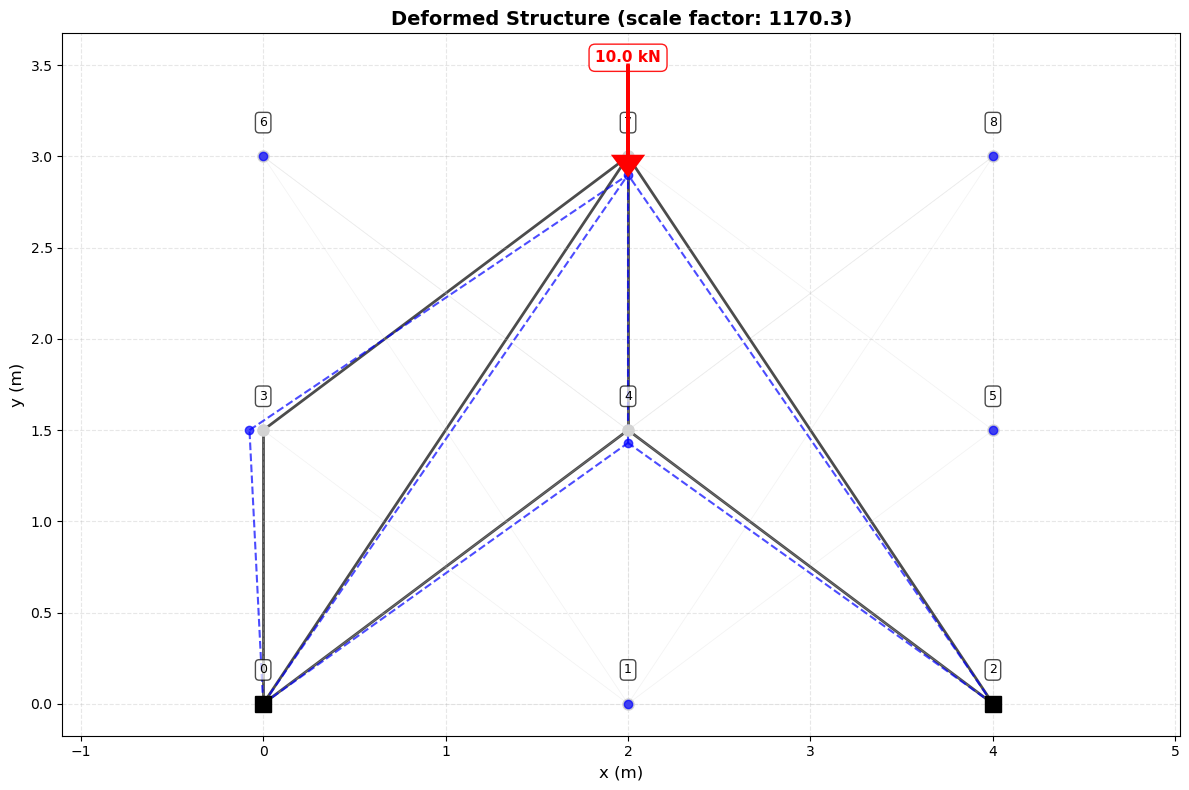

In [8]:
u_search, valid_opt = fem_model.solve(random_search_design, loads, fixed_dofs)

metrics = fem_model.evaluate_design(random_search_design, loads, fixed_dofs, 
                                    u_hat=u_hat, sigma_hat=sigma_hat)

fem_model.print_metrics(metrics)
scale_factor = 0.1/abs(u_search).max()
fem_model.plot_truss(design=random_search_design, loads=loads, fixed_dofs=fixed_dofs,
                    displacements=u_search, scale_factor=scale_factor,
                    show_labels=True,
                    title=f"Deformed Structure (scale factor: {scale_factor:.1f})")



## Simulated Annealing

Starting SA: T_init=1000, T_min=0.1, alpha=0.99
Iteration 10000: T=366.03, Best fitness=168.78
Iteration 20000: T=133.98, Best fitness=168.78
Iteration 30000: T=49.04, Best fitness=168.78
Iteration 40000: T=17.95, Best fitness=168.78
Iteration 50000: T=6.57, Best fitness=168.78
Iteration 60000: T=2.41, Best fitness=168.78
Iteration 70000: T=0.88, Best fitness=168.78
Iteration 80000: T=0.32, Best fitness=168.78
Iteration 90000: T=0.12, Best fitness=168.78

SA completed after 91700 iterations
Best fitness: 168.78
  Weight: 168.78 kg
  Max displacement: 0.2486 mm
  Max stress: 10.00 MPa
  Compliance: 2.49 J
  Feasible: True


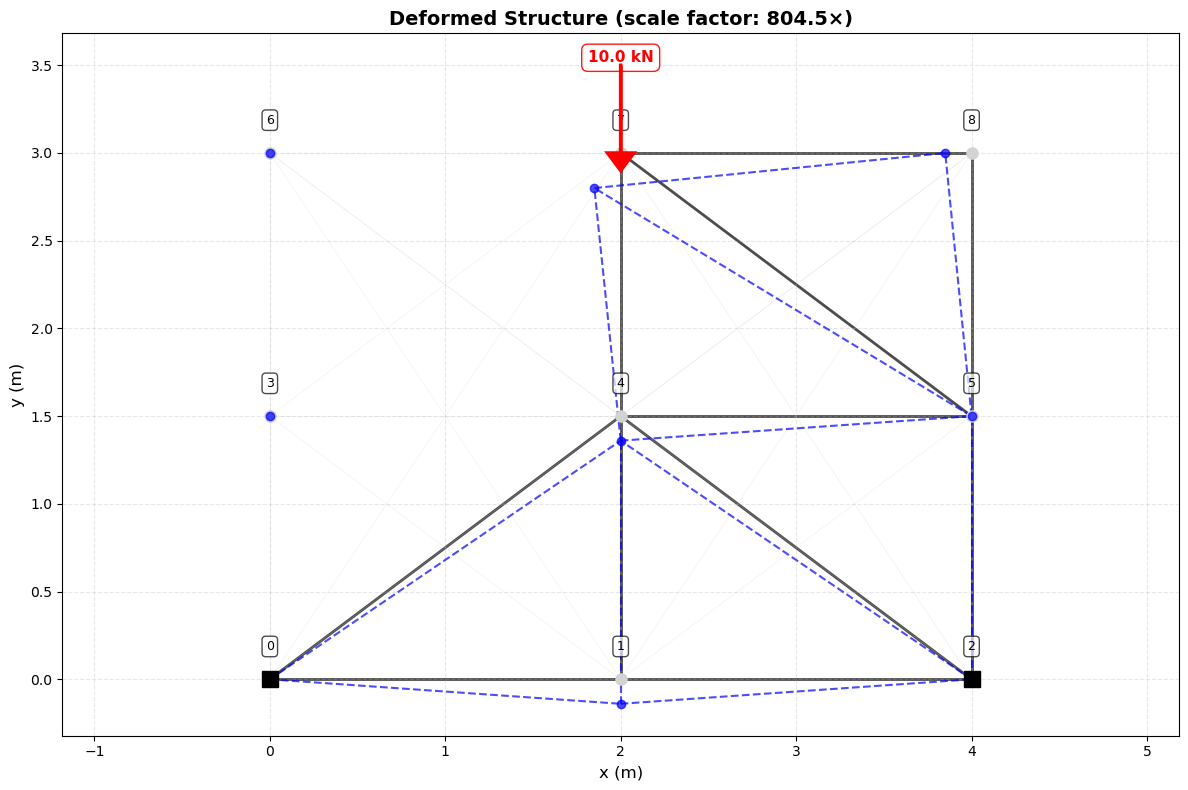

In [9]:
best_SA_design = simulated_annealing(fem_model, loads, fixed_dofs, N,
                       T_init=1000, T_min=0.1, alpha=0.99, 
                       steps_per_temp=100)

u_opt, valid_opt = fem_model.solve(best_SA_design, loads, fixed_dofs)

metrics = fem_model.evaluate_design(best_SA_design, loads, fixed_dofs, 
                                    u_hat=u_hat, sigma_hat=sigma_hat)

fem_model.print_metrics(metrics)
scale_factor = 0.2/abs(u_opt).max()
fem_model.plot_truss(design=best_SA_design, loads=loads, fixed_dofs=fixed_dofs,
                    displacements=u_opt, scale_factor=scale_factor,
                    show_labels=True,
                    title=f"Deformed Structure (scale factor: {scale_factor:.1f}×)")
